In [95]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_ta as ta

In [200]:
import MetaTrader5 as mt5
from account_credentials import LOGIN,PASSWORD,SERVER
from datetime import datetime


is_initialized = mt5.initialize()
print('initialize: ', is_initialized)

is_logged_in = mt5.login(LOGIN, PASSWORD, SERVER)
print('logged in: ', is_logged_in)
print('\n')
account_info = mt5.account_info()
print(datetime.now(),
    '| Login: ', account_info.login,
    '| Balance: ', account_info.balance,
    '| Equity: ' , account_info.equity)

initialize:  True
logged in:  True


2023-04-20 11:56:36.213473 | Login:  114123121 | Balance:  522.59 | Equity:  520.95


In [201]:
symbol = 'XAUUSD'
number_of_date= 10000
timeframe = mt5.TIMEFRAME_H1
from_date = datetime.now()

df = pd.DataFrame(mt5.copy_rates_from(symbol,timeframe,from_date,number_of_date))
df["time"] = pd.to_datetime(df["time"], unit="s")
df = df.rename(columns={'time': 'date','tick_volume':'volume'})
df = df[['date','open','high','low','close','volume']]
df = df.set_index("date")
print(df.head()) # just to make sure that sorted from old to new

                         open      high       low     close  volume
date                                                               
2021-08-10 13:00:00  1727.645  1729.903  1721.020  1721.931   10099
2021-08-10 14:00:00  1721.963  1727.258  1717.741  1726.512    9855
2021-08-10 15:00:00  1726.482  1732.713  1725.512  1731.500    5555
2021-08-10 16:00:00  1731.468  1732.430  1729.202  1729.405    3733
2021-08-10 17:00:00  1729.372  1732.042  1729.304  1731.108    3142


##### Adding Features

In [202]:
df['RSI'] = ta.rsi(df.close, length = 15)
df['EMAF'] = ta.ema(df.close, length = 20)
df['EMAM'] = ta.ema(df.close, length = 100)
df['EMAS'] = ta.ema(df.close, length = 150)
# df['Target'] = df['close'] - df.open
# df['Target'] = df['Target'].shift(-1)

# df['TargetClass'] = [1 if df.Target[i] > 0 else 0 for i in range(len(df))]
df['Target-Next-Close'] = df['close'].shift(-1)



df.dropna(inplace = True)
df.reset_index(inplace = True)
df.drop(['date','volume'], axis=1 , inplace=True)
df = df[0:100]
df

,open,high,low,close,RSI,EMAF,EMAM,EMAS,Target-Next-Close
0,1787.417,1787.455,1784.101,1784.401,46.055640,1786.273216,1775.707573,1766.475447,1781.882
1,1784.447,1785.409,1781.516,1781.882,41.687587,1785.855005,1775.829839,1766.679507,1780.905
2,1781.871,1782.370,1780.493,1780.905,40.106872,1785.383576,1775.930338,1766.867924,1779.916
3,1780.909,1780.909,1774.199,1779.916,38.522608,1784.862855,1776.009262,1767.040746,1777.501
4,1779.914,1780.000,1776.978,1777.501,34.914357,1784.161726,1776.038801,1767.179293,1778.840
...,...,...,...,...,...,...,...,...,...
95,1795.911,1796.016,1793.819,1794.851,36.282201,1800.731590,1792.735352,1786.512200,1794.188
96,1794.850,1794.985,1791.830,1794.188,35.159931,1800.108391,1792.764117,1786.613867,1795.028
97,1794.204,1796.759,1793.473,1795.028,37.772773,1799.624544,1792.808946,1786.725312,1793.541
98,1795.032,1797.431,1793.248,1793.541,35.090780,1799.045159,1792.823442,1786.815586,1794.402


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler_x = StandardScaler().fit(df.iloc[:,:8])
scaled_x = scaler_x.transform(df.iloc[:,:8])
scaler_y = StandardScaler().fit(df.iloc[:,8].values.reshape(-1, 1))
scaled_y = scaler_y.transform(df.iloc[:,8].values.reshape(-1, 1))
scaled_x.shape

In [242]:
df_a = np.array(df)
# df.iloc[:,0].to_csv('ttt.csv')
df.iloc[30:,0]


30    1787.492
31    1785.438
32    1782.556
33    1781.762
34    1784.921
        ...   
95    1795.911
96    1794.850
97    1794.204
98    1795.032
99    1793.582
Name: open, Length: 70, dtype: float64

In [283]:
X = []
backcandles = 30
print(df_a.shape[0])
for j in range(8): 
    X.append([])
    for i in range(0, df_a.shape[0]-backcandles):
        X[j].append(df_a[i:i+backcandles, j])
print(np.array(X).shape)

X = np.moveaxis(X, [0], [2])  # move the feature axis to the second dimension
print(X.shape)

100
(8, 70, 30)
(70, 30, 8)


In [282]:
X[-1,30,0]

1793.582

In [274]:
X = []
backcandles = 30
print(df_a.shape[0])
for j in range(8): # grabe open	high	low	close	RSI	EMAF	EMAM	EMAS
    X.append([])
    for i in range(backcandles, df_a.shape[0]):
        X[j].append(df_a[i-backcandles:i, j])
X=np.moveaxis(X, [0], [2])
X.shape


100


(70, 30, 8)

In [191]:
X = []
backcandles = 30
print(scaled_x.shape[0])
for j in range(8): 
    X.append([])
    for i in range(backcandles, scaled_x.shape[0]):
        X[j].append(scaled_x[i-backcandles:i, j])
X = np.moveaxis(X, [0], [2])  # move the feature axis to the second dimension
X = X[::-1]  # reverse the order of the samples to put the most recent data at the end
X.shape


9850


(9820, 30, 8)

In [193]:
X[0,0,:]

array([2004.067     , 2005.593     , 2003.386     , 2005.291     ,
         53.30622865, 2002.96640619, 2008.37616618, 2007.79507329])

In [158]:
X = []
backcandles = 30
print(scaled_x.shape[0])
for j in range(8): # grabe open	high	low	close	RSI	EMAF	EMAM	EMAS
    X.append([])
    for i in range(backcandles, scaled_x.shape[0]):
        X[j].append(scaled_x[i-backcandles:i, j])

9850


In [159]:
X=np.moveaxis(X, [0], [2])
X.shape

(9820, 30, 8)

In [165]:
X[0,1,:]

array([1787.417     , 1787.455     , 1784.101     , 1784.401     ,
         46.0552878 , 1786.27321638, 1775.72117332, 1766.33968706])

array([2004.067     , 2005.593     , 2003.386     , 2005.291     ,
         53.30622865, 2002.96640619, 2008.37616618, 2007.79507329])

In [44]:
X = np.array(X)
y = np.array(scaled_y[30:,-1])
# y = np.reshape(y,(len(y),1))
print(X.shape) # 3D X has 8 colume and each colume contain xx backcandles (row, backcandle, column)
print(y.shape) # 2D contain 1 value (it's 1D array that reshape into 2D array)
print(y[0:10])

(9820, 30, 8)
(9820,)
[-0.37614532 -0.40823764 -0.41734507 -0.38163255 -0.38540075 -0.41336057
 -0.42037329 -0.40970621 -0.38139348 -0.39390482]


In [45]:
proportion = int(len(X)*0.8)
X_train, X_test = X[:proportion],X[proportion:]
y_train, y_test = y[:proportion],y[proportion:]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X[1,1:10,1])

(7856, 30, 8)
(7856,)
(1964, 30, 8)
(1964,)
[-0.40046481 -0.43497509 -0.45156592 -0.46188834 -0.46216088 -0.43688287
 -0.43097785 -0.37304056 -0.35069234]


In [46]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Define the Sequential model
model = Sequential()

# Add the LSTM layer with 150 units and input shape (backcandles, 8)
model.add(LSTM(units=150, input_shape=(backcandles, 8), name='lstm_layer'))

# Add a dense layer with a single output neuron and linear activation function
model.add(Dense(units=1, activation='linear', name='output'))

# Compile the model with the Adam optimizer and mean squared error loss function
model.compile(optimizer='adam', loss='mse')

# Train the model on the training data with a batch size of 15 and for 30 epochs
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_data=(X_test, y_test))


Epoch 1/30
524/524 [==============================] - 7s 10ms/step - loss: 0.0091 - val_loss: 0.0113
Epoch 2/30
524/524 [==============================] - 5s 10ms/step - loss: 0.0041 - val_loss: 0.0047
Epoch 3/30
524/524 [==============================] - 5s 10ms/step - loss: 0.0038 - val_loss: 0.0052
Epoch 4/30
524/524 [==============================] - 5s 9ms/step - loss: 0.0036 - val_loss: 0.0039
Epoch 5/30
524/524 [==============================] - 5s 9ms/step - loss: 0.0036 - val_loss: 0.0040
Epoch 6/30
524/524 [==============================] - 5s 9ms/step - loss: 0.0035 - val_loss: 0.0040
Epoch 7/30
524/524 [==============================] - 5s 9ms/step - loss: 0.0034 - val_loss: 0.0049
Epoch 8/30
524/524 [==============================] - 5s 9ms/step - loss: 0.0035 - val_loss: 0.0042
Epoch 9/30
524/524 [==============================] - 5s 9ms/step - loss: 0.0034 - val_loss: 0.0037
Epoch 10/30
524/524 [==============================] - 5s 9ms/step - loss: 0.0034 - val_loss: 0.0

In [47]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_layer (LSTM)           (None, 150)               95400     
                                                                 
 output (Dense)              (None, 1)                 151       
                                                                 
Total params: 95,551
Trainable params: 95,551
Non-trainable params: 0
_________________________________________________________________


In [48]:
y_hat = model.predict(X_test)

62/62 [==============================] - 0s 4ms/step


In [49]:
y_hat_inverse = scaler_y.inverse_transform(y_hat)
print(y_hat_inverse)
y_test_inverse = scaler_y.inverse_transform(y_test.reshape(-1, 1))
print(y_test_inverse)

[[1781.2336]
 [1783.1385]
 [1785.3759]
 ...
 [1990.7444]
 [1993.2899]
 [1993.2131]]
[[1785.151]
 [1785.439]
 [1792.185]
 ...
 [1995.715]
 [1991.769]
 [1991.455]]


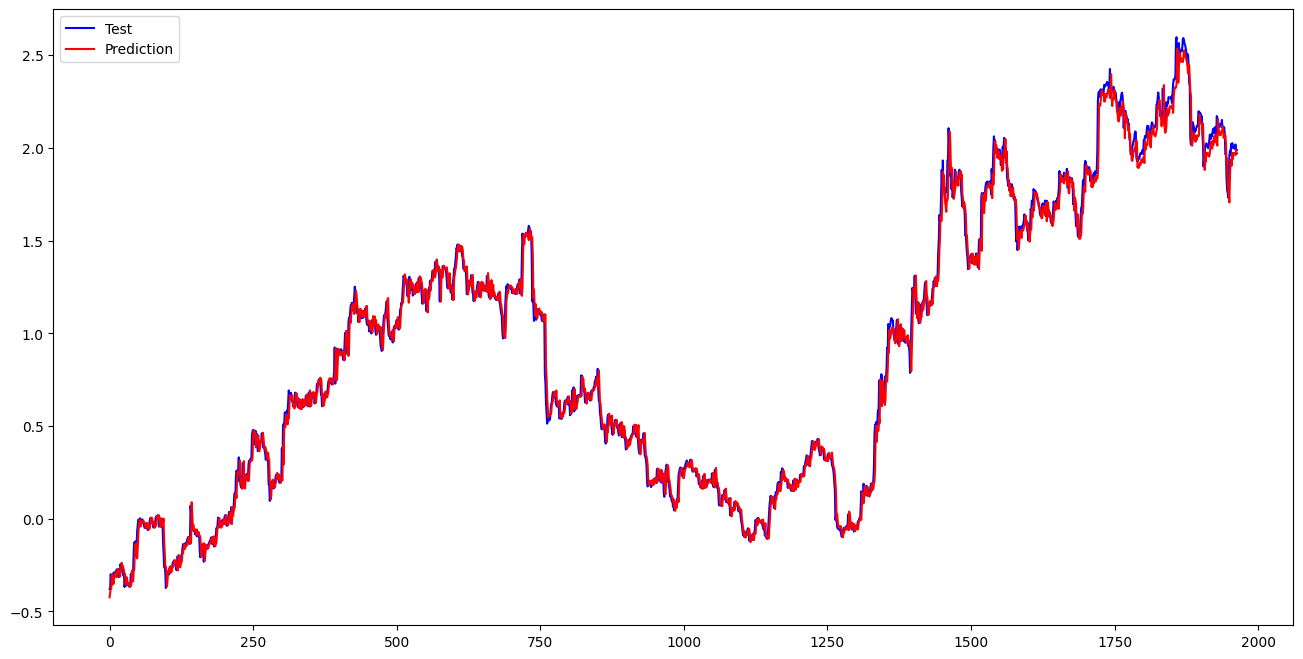

In [50]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'blue', label = 'Test')
plt.plot(y_hat, color = 'red', label = 'Prediction')
plt.legend()
plt.show()

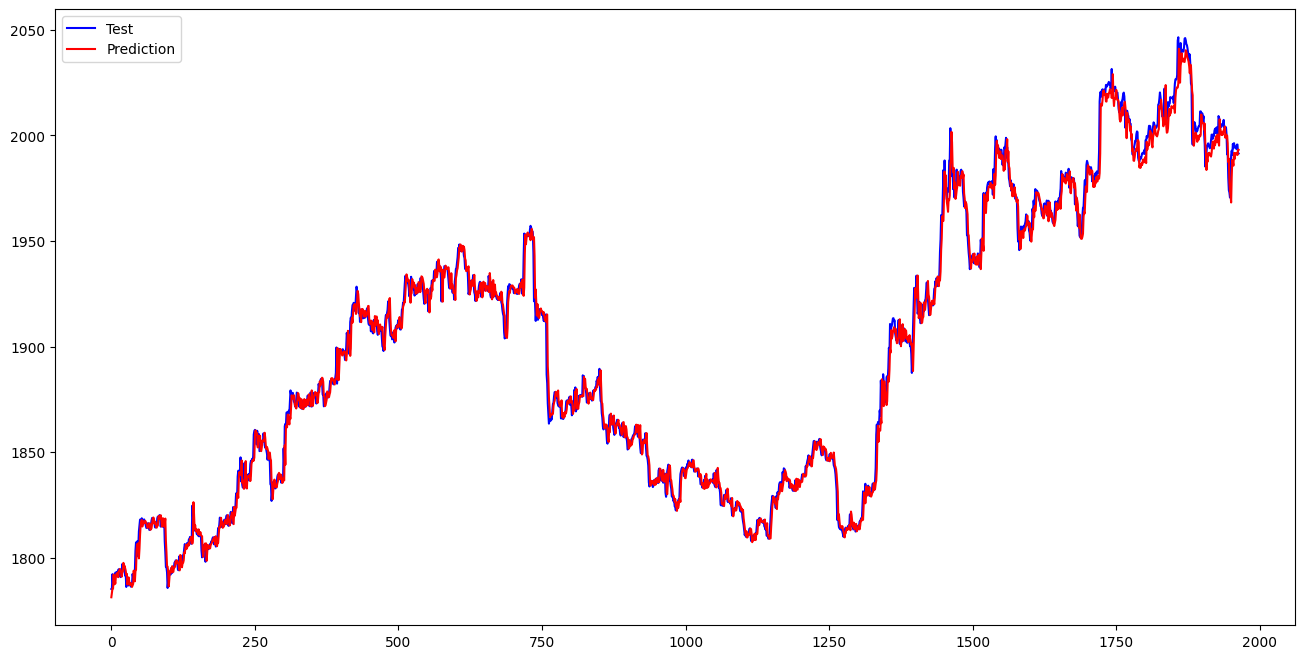

In [51]:
plt.figure(figsize=(16,8))
plt.plot(y_test_inverse, color = 'blue', label = 'Test')
plt.plot(y_hat_inverse, color = 'red', label = 'Prediction')
plt.legend()
plt.show()

In [52]:
# Evaluate the model on the test data
loss = model.evaluate(X_test, y_test)

# Print the mean squared error loss
print('Test loss:', loss)

# Generate predictions on the test data
y_pred = model.predict(X_test)

# Compute the mean squared error (MSE) and root mean squared error (RMSE)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Compute the coefficient of determination (R-squared)
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)

# Print the performance metrics
print("TEST SET")
print('Mean squared error (MSE):', mse)
print('Root mean squared error (RMSE):', rmse)
print('R-squared (R2):', r2)
print()

loss = model.evaluate(X_train, y_train)
print('Training loss:', loss)

y_pred = model.predict(X_train)

mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)

r2 = r2_score(y_train, y_pred)
print("TRAINING SET")
print('Mean squared error (MSE):', mse)
print('Root mean squared error (RMSE):', rmse)
print('R-squared (R2):', r2)

62/62 [==============================] - 0s 4ms/step - loss: 0.0038
Test loss: 0.0038412814028561115
62/62 [==============================] - 0s 4ms/step
TEST SET
Mean squared error (MSE): 0.0038412806028078963
Root mean squared error (RMSE): 0.061978065497463666
R-squared (R2): 0.9936136022867613

246/246 [==============================] - 1s 4ms/step - loss: 0.0029
Training loss: 0.002942304592579603
246/246 [==============================] - 1s 4ms/step
TRAINING SET
Mean squared error (MSE): 0.0029423051823522367
Root mean squared error (RMSE): 0.05424301966476642
R-squared (R2): 0.9965431614771452


In [ ]:
if prediction - close > 3 then buy
if target > 3 then buy is correct
This is correct
else false

if prediction - close < 3 then sell
if target > 3 then sell is correct
This is correct
else false

if prediction - close > 3 AND prediction - close < 3 then doing nothing

# with a single model it cannot predict sell and buy at the sametime

In [91]:
# float(model.predict(X_test[0, :, :].reshape(1, 30, 8)))
# y_hat = model.predict(X_test)
# float(y_hat[0])
scaled_sample_x = scaler_x.inverse_transform(X_train[0, :, :])
scaled_sample_x[0,4]
# y_test_inverse = scaler_y.inverse_transform(y_test.reshape(-1, 1))

52.167616617369006

In [ ]:
def predict_simu(model, X_test, data_simu_y, initial_capital):
    capital = initial_capital
    win_count = 0
    lost_count = 0
    no_order_count = 0
    record_result = []
    record_capital = []
    record_date = []
    consecutive_lost = 0
    consecutive_lost_max = 0
    for i in range(0, len(X_test)):
        prediction = float(model.predict(X_test[0, :, :].reshape(1, 30, 8)))
        
        if prediction == 1 and data_simu_y[i] == 1:
            outcome = 3
            capital += outcome
            win_count += 1
            order_record = 'win-------- prediction = {0}, actual = {1}'.format(prediction,data_simu_y[i])
            result = 'win'
        elif prediction == 1 and data_simu_y[i] == 0:
            outcome = -3.3
            capital += outcome
            lost_count += 1
            order_record = 'lost------- prediction = {0}, actual = {1}'.format(prediction,data_simu_y[i])
            result = 'lost'
        elif prediction == 0:
            no_order_count +=1
            order_record = 'no order--- prediction = {0}, actual = {1}'.format(prediction, data_simu_y[i])
            capital = capital
            result = 'no order'
        else:
            raise ValueError('no condition met')
        record_date.append(X_test.iloc[i].name)
        record_result.append(order_record)
        record_capital.append(capital)

        #Calculate Consecutive Lost
        if result == 'lost':
            consecutive_lost += -3.3
            if consecutive_lost <= consecutive_lost_max:
                consecutive_lost_max = consecutive_lost
        if result == 'win':
            if consecutive_lost <= consecutive_lost_max:
                consecutive_lost_max = consecutive_lost
            consecutive_lost = 0

    total_return = ((capital - initial_capital) / initial_capital)*100
    sim_df = pd.DataFrame({'record_date':record_date,
                           'record_result':record_result,
                           'record_capital': record_capital})
    sim_df.set_index('record_date', inplace=True)

    return win_count, lost_count, no_order_count, capital, total_return, sim_df, consecutive_lost_max
